In [1]:
import pandas as pd
from plot_triad import plot_triad_eop
from eop_simple import compute_eop_from_triads, EOPOpts

In [2]:
policies_CL = [
    ("2021-04-01", "Ley 21325 \nApril 2021", "red"),
    ("2021-03-01", "US Policy", "yellow")
]

policies_PE = [
    ("2019-07-15", "Visa Requirement\nJune 2019", "Red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2021-07-01", "Temporary Permit Carnet (CPT)\nJuly 2021", "green"),
    ("2021-10-22", "CPT Implementation\nOctober 2021", "red")
]

policies_EC = [
    ("2019-07-25", "Presidential Decree 826\nJuly 2019", "red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2019-08-26", "VIRTE\nBefore July 2019", "blue"),
    ("2022-06-01", "VIRTE\nSep 2022 to Aug 2023", "blue")
]

In [3]:
# ---- 1) Paths (EDIT THESE) ----
pred_path = "/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/2weight_LA.csv"   
# flows_path = "/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/df_flow.csv" 
train_end = "2021-12-01"     # training window end used by CF++

# ---- 2) Load ----
pred = pd.read_csv(pred_path)
# flows = pd.read_csv(flows_path)
pred

,orig,dest,month,flow,mu_hat,excess_pct,weight,weight_ratio
0,AR,BO,2019-01-01,3325.0,1410.899549,1.356653,0.000000,0.000000
1,AR,BO,2019-02-01,3275.0,1609.262413,1.035094,0.000000,0.000000
2,AR,BO,2019-03-01,2686.0,1776.958044,0.511572,0.000000,0.000000
3,AR,BO,2019-04-01,2089.0,1646.620301,0.268659,0.000000,0.000000
4,AR,BO,2019-05-01,2084.0,1644.943964,0.266912,0.000000,0.000000
...,...,...,...,...,...,...,...,...
20155,VE,UY,2022-08-01,122.0,283.244791,-0.569277,0.073680,0.471249
20156,VE,UY,2022-09-01,121.0,276.464534,-0.562331,0.072903,0.466278
20157,VE,UY,2022-10-01,161.0,341.360665,-0.528358,0.078581,0.502593
20158,VE,UY,2022-11-01,149.0,271.568473,-0.451335,0.095230,0.609081


# Build i-j-k

In [4]:
pred['month'] = pd.to_datetime(pred['month'])

# Left side: i -> j edges (we want weight info)
edges_ij = (
    pred[['orig','dest','month','weight','weight_ratio']]
      .rename(columns={
          'orig':'i',
          'dest':'j',
          'weight':'weight_ij',
          'weight_ratio':'weight_ratio_ij'
      })
)

# Right side: j -> k edges (we want mu_hat & excess_pct)
edges_jk = (
    pred[['orig','dest','month','mu_hat','excess_pct']]
      .rename(columns={
          'orig':'j',
          'dest':'k',
          'mu_hat':'mu_hat_jk',
          'excess_pct':'excess_pct_jk'
      })
)

# Join on month and the shared middle node j
triples = edges_ij.merge(edges_jk, on=['month','j'], how='inner')

# Optional: reorder/select columns
triples = triples[['month','i','j','k','excess_pct_jk','mu_hat_jk','weight_ij','weight_ratio_ij']]

# Optional: if you want to drop paths where i == k (cycles), uncomment:
triples = triples[triples['i'] != triples['k']]
triples

,month,i,j,k,excess_pct_jk,mu_hat_jk,weight_ij,weight_ratio_ij
1,2019-01-01,AR,BO,BR,0.114119,1791.549988,0.000000,0.000000
2,2019-01-01,AR,BO,CA,-0.089891,23.074167,0.000000,0.000000
3,2019-01-01,AR,BO,CL,-0.064599,2215.093669,0.000000,0.000000
4,2019-01-01,AR,BO,CO,-0.182769,122.364374,0.000000,0.000000
5,2019-01-01,AR,BO,CR,1.122404,8.952113,0.000000,0.000000
...,...,...,...,...,...,...,...,...
403194,2022-12-01,VE,UY,PA,0.181943,13.537032,0.110956,0.709658
403195,2022-12-01,VE,UY,PE,-0.518881,78.982570,0.110956,0.709658
403196,2022-12-01,VE,UY,PY,-0.730790,66.862412,0.110956,0.709658
403197,2022-12-01,VE,UY,SR,-1.000000,9.027597,0.110956,0.709658


In [15]:
# pred[(pred['orig'] == 'VE') & (pred['dest'] == 'UY')]

# Calculation

In [17]:
# Configure

opts = EOPOpts(
    train_end="2021-12-01",  # end of training window for phi estimation
    # weight_col="weight_ij",   
    weight_col="weight_ratio_ij" # or
)

# Compute EOP
eop_ratio = compute_eop_from_triads(triples, opts)
eop_ratio

,month,i,j,k,flow_jk,mu_hat_jk,excess_pct_jk,z_std_jk,weight_ratio_ij,EOP_pct,EOP_z
0,2019-01-01,AR,BO,BR,1996.0,1791.549988,0.114119,0.389249,0.000000,0.000000,0.000000
1,2019-02-01,AR,BO,BR,2289.0,2043.429710,0.120176,0.437775,0.000000,0.000000,0.000000
2,2019-03-01,AR,BO,BR,2255.0,2256.368403,-0.000606,-0.002321,0.000000,-0.000000,-0.000000
3,2019-04-01,AR,BO,BR,1597.0,2090.866484,-0.236202,-0.870366,0.000000,-0.000000,-0.000000
4,2019-05-01,AR,BO,BR,1538.0,2088.737884,-0.263670,-0.971087,0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
383035,2022-08-01,VE,UY,US,409.0,422.851388,-0.032757,-0.054282,0.471249,-0.015437,-0.025580
383036,2022-09-01,VE,UY,US,301.0,412.729257,-0.270708,-0.443190,0.466278,-0.126225,-0.206650
383037,2022-10-01,VE,UY,US,381.0,509.611599,-0.252372,-0.459109,0.502593,-0.126840,-0.230745
383038,2022-11-01,VE,UY,US,238.0,405.420009,-0.412954,-0.670054,0.609081,-0.251523,-0.408118


In [23]:
eop.sort_values(by="EOP_z", ascending=False).head(20)

,month,i,j,k,flow_jk,mu_hat_jk,excess_pct_jk,z_std_jk,weight_ij,EOP_pct,EOP_z
121199,2022-12-01,CR,NI,US,34156.0,3394.842264,9.061145,42.544965,0.583787,5.289775,24.837182
121198,2022-11-01,CR,NI,US,16742.0,2325.700863,6.198690,24.089742,0.588805,3.649817,14.184151
370220,2022-09-01,VE,CO,US,25546.0,7117.501902,2.589181,17.602787,0.769285,1.991818,13.541562
370221,2022-10-01,VE,CO,US,29362.0,8788.234574,2.341058,17.685537,0.764102,1.788807,13.513557
370223,2022-12-01,VE,CO,US,31307.0,10205.475910,2.067667,16.832650,0.768889,1.589806,12.942435
370219,2022-08-01,VE,CO,US,24812.0,7292.057701,2.402606,16.533428,0.774831,1.861614,12.810615
369791,2022-12-01,VE,CO,ES,29924.0,10459.783352,1.860862,15.336663,0.768889,1.430796,11.792188
370218,2022-07-01,VE,CO,US,23246.0,7187.960482,2.234019,15.263178,0.764524,1.707961,11.669063
370217,2022-06-01,VE,CO,US,23932.0,7653.662094,2.126869,14.994456,0.757261,1.610594,11.354709
339453,2022-10-01,US,MX,CA,12232.0,2490.782756,3.910906,15.728981,0.694530,2.716243,10.924257


In [22]:
eop_ratio.sort_values(by="EOP_pct", ascending=False).head(20)

,month,i,j,k,flow_jk,mu_hat_jk,excess_pct_jk,z_std_jk,weight_ratio_ij,EOP_pct,EOP_z
48114,2020-07-01,BR,NI,PY,14.0,1.514674,8.242914,0.817515,3.237101,26.683144,2.646378
362291,2021-12-01,UY,SR,CL,103.0,15.185111,5.782960,1.815994,4.167224,24.098887,7.567654
371633,2020-06-01,VE,DO,GY,16.0,1.865877,7.575056,0.833840,3.007601,22.782747,2.507858
306659,2021-12-01,PY,SR,CL,103.0,15.185111,5.782960,1.815994,3.806667,22.013805,6.912886
251939,2021-12-01,NI,SR,CL,103.0,15.185111,5.782960,1.815994,3.770755,21.806125,6.847669
270179,2021-12-01,PA,SR,CL,103.0,15.185111,5.782960,1.815994,3.576876,20.684932,6.495586
359154,2020-07-01,UY,NI,PY,14.0,1.514674,8.242914,0.817515,2.489949,20.524431,2.035570
233699,2021-12-01,MX,SR,CL,103.0,15.185111,5.782960,1.815994,3.435620,19.868054,6.239067
362292,2022-01-01,UY,SR,CL,133.0,23.364145,4.692483,1.827818,4.167224,19.554626,7.616926
377394,2020-07-01,VE,NI,PY,14.0,1.514674,8.242914,0.817515,2.369004,19.527498,1.936696


## Export

In [24]:
# eop.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/eop_LA.csv", index=False)
# eop_ratio.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/eop_ratio_LA.csv", index=False)

# eop = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/eop_LA.csv")

# Check result

In [31]:
# 2022 annual means - EOP
# EOP_type = 'EOP_z'
EOP_type = 'EOP_pct'

eop['year'] = pd.to_datetime(eop['month']).dt.year
ann_2022 = (eop[eop['year']==2022]
            .groupby(['i','j','k',])[EOP_type]
            .mean()
            .reset_index()
            .sort_values(['i','j','k']))
print("2022 means:")
ann_2022.sort_values(by=EOP_type, ascending=False).head(20)

2022 means:


,i,j,k,EOP_pct
2524,CR,NI,US,2.471371
7071,US,MX,CA,1.448731
7712,VE,CO,US,1.286792
7902,VE,PE,US,1.181774
7703,VE,CO,ES,0.872736
293,AR,PY,ES,0.822697
5583,PA,NI,US,0.631809
5070,NI,CR,US,0.630705
7699,VE,CO,CL,0.579493
7888,VE,PE,CA,0.544462


In [39]:
# 2022 annual means - Eop_ratio
EOP_type = 'EOP_z'
# EOP_type = 'EOP_pct'

eop_ratio['year'] = pd.to_datetime(eop_ratio['month']).dt.year
ann_2022_ratio = (eop_ratio[eop_ratio['year']==2022]
            .groupby(['i','j','k',])[EOP_type]
            .mean()
            .reset_index()
            .sort_values(['i','j','k']))
print("2022 means:")
ann_2022_ratio.sort_values(by=EOP_type, ascending=False).head(20)

2022 means:


,i,j,k,EOP_z
2144,CO,NI,US,24.718761
3664,ES,NI,US,21.952663
4804,MX,NI,US,21.916859
3284,EC,NI,US,21.451401
6343,PY,NI,US,21.311279
4424,HT,NI,US,21.005413
5583,PA,NI,US,20.909447
7484,UY,NI,US,20.448713
624,BO,NI,US,19.833660
1384,CA,NI,US,19.578984


In [26]:
# Peak month per triad & window
peaks = (eop.sort_values(['i','j','k','EOP_pct'], ascending=[True,True,True,False])
           .groupby(['i','j','k'])
           .head(10)[['i','j','k','month','EOP_pct']])
print("Peaks:")
peaks

Peaks:


,i,j,k,month,EOP_pct
12,AR,BO,BR,2020-01-01,0.477668
17,AR,BO,BR,2020-06-01,0.396464
16,AR,BO,BR,2020-05-01,0.368586
22,AR,BO,BR,2020-11-01,0.367261
15,AR,BO,BR,2020-04-01,0.266393
...,...,...,...,...,...
383025,VE,UY,US,2021-10-01,0.077477
383020,VE,UY,US,2021-05-01,0.075401
383026,VE,UY,US,2021-11-01,0.053319
383027,VE,UY,US,2021-12-01,0.028259


# Plot

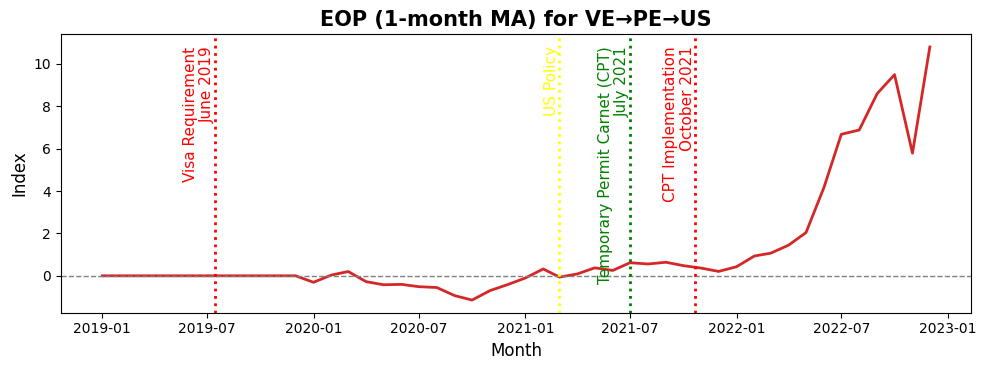

In [35]:
eopPE = eop[(eop['i'] == 'VE') & (eop['j'] == 'PE') & (eop['k'] == 'US')]

plot_triad_eop(
    eopPE,
    i="VE", j="PE", k="US",
    ma=1,
    policies=policies_PE,
    line_colors={"eop": "tab:red"},
    eop_col="EOP_z",
)

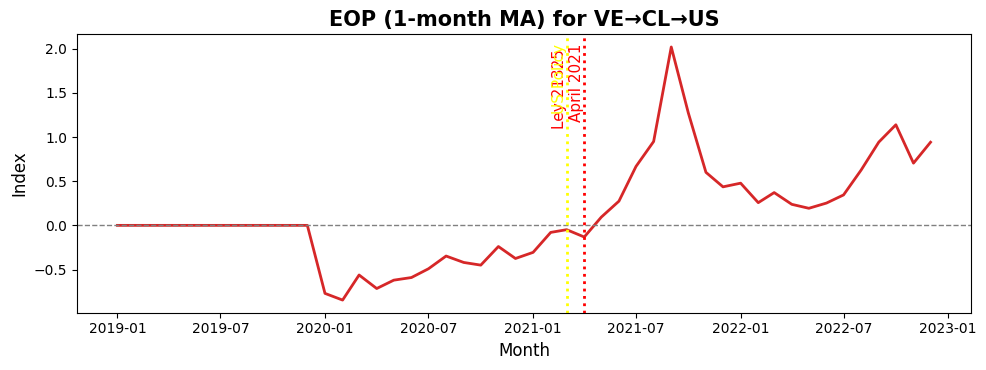

In [37]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'CL') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="CL", k="US",
    ma=1,
    policies=policies_CL,
    # policies=[("2022-03-01", "Policy Change", "tab:green")],
    line_colors={"eop": "tab:red"},
    eop_col="EOP_z",
)

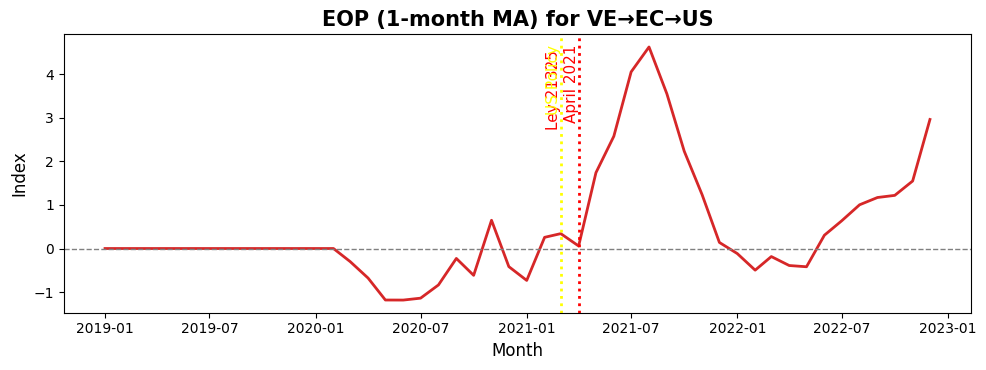

In [34]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'EC') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="EC", k="US",
    ma=1,
    policies=policies_CL,
    # policies=[("2022-03-01", "Policy Change", "tab:green")],
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)

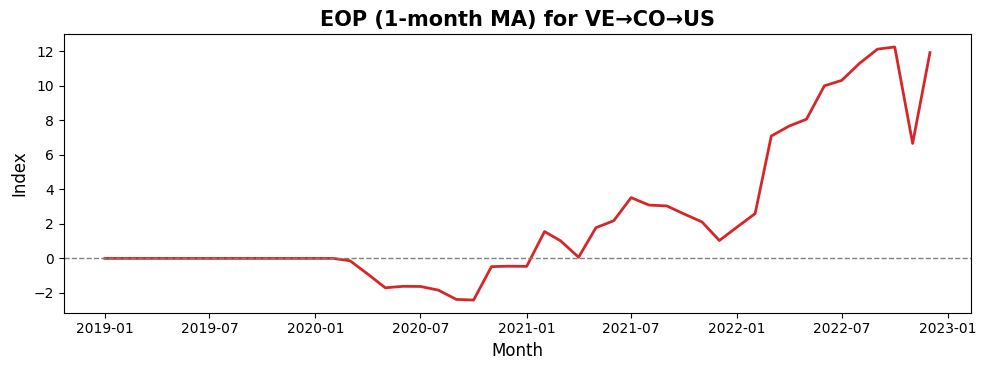

In [35]:
eopCL = eop[(eop['i'] == 'VE') & (eop['j'] == 'CO') & (eop['k'] == 'US')]

plot_triad_eop(
    eopCL,
    i="VE", j="CO", k="US",
    ma=1,
    # policies=policies_CO,
    line_colors={"eop": "tab:red"},
    eop_col="EOP",
)